In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 确认我们的电脑支持CUDA，然后显示CUDA信息：

print(device)

cuda:0


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./cifar-10-batches-py', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./cifar-10-batches-py', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


 frog  deer horse  frog


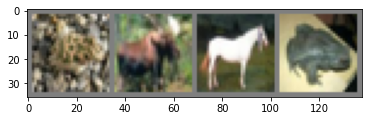

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 展示图像的函数


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# 获取随机数据
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 展示图像
imshow(torchvision.utils.make_grid(images))
# 显示图像标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F

#卷积尺度计算公式：（原尺寸-卷积核大小）/
# 输入图片大小 W×W
# Filter大小 F×F
# 步长 S
# padding的像素数 P,padding为填充数
# N = (W − F + 2P )/S+1

# 输出图片大小为 N×N
#TODO
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3卷积带有padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1卷积"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    # 基本的block类
    expansion = 1  # 扩张值，用于通道数倍增

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        """
        inplanes:   输入通道数
        planes:     输出通道数
        stride:     步长
        downsample: 下采样层
        groups:     组数，当为1时不进行分组卷积
        base_width: 基本宽度
        dilation:   膨胀率
        norm_layer: 归一化层
        """
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # 组数不等于1或则基本宽度不等于64，则报错，表明只支持组数为1，且base_width为64
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        # 膨胀只能为1，
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)  # 3x3卷积层
        self.bn1 = norm_layer(planes) # BN层
        self.relu = nn.ReLU(inplace=True)  # Relu层
        self.conv2 = conv3x3(planes, planes)   # 3x3卷积层
        self.bn2 = norm_layer(planes)  # BN层
        self.downsample = downsample  # 下采样层
        self.stride = stride  # 步长

    def forward(self, x):
        identity = x  # 恒等值

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:  # 如果下采样层不为None，则进行下采样处理。
            identity = self.downsample(x) 

        out += identity  # 残差连接，与原来x相加
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4  # 扩张值，用于通道数倍增

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups   # 重新计算输出层
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)  # 1x1卷积层
        self.bn1 = norm_layer(width)  # BN层
        self.conv2 = conv3x3(width, width, stride, groups, dilation)  # 3x3卷积层
        self.bn2 = norm_layer(width)  # BN层
        self.conv3 = conv1x1(width, planes * self.expansion)  # 1x1卷积层
        self.bn3 = norm_layer(planes * self.expansion)  # BN层
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample  # 下采样层
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        # block基本模块类BasicBlock（18,34）或者Bottleneck（50,101,152），
        # layes=[2, 2, 2, 2]是每个layer的重复次数， num_classes类别数
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d  # norm_layer未指定，默认为nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64  # 输入通道数
        self.dilation = 1   # 不采用空洞卷积，即膨胀率为1
        if replace_stride_with_dilation is None: # 替换步长用膨胀率，如果为None，设置默认值为[False, False, False]
            # each element in the tuple indicates if we should replace
            # tuple中的每个元素都表示是否应该替换
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:  # 检查是否为None或者长度为3
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups  # 组数为1
        self.base_width = width_per_group   # 每个组为64
        #TODO
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=5, stride=2, padding=3,
                               bias=False)   # 第一个卷积层，（3,64,7,2,3）
        self.bn1 = norm_layer(self.inplanes) # nn.BatchNorm2d层
        self.relu = nn.ReLU(inplace=True)    # relu层
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 最大池化层
        self.layer1 = self._make_layer(block, 64, layers[0])  # 输出层数64，该层重复2次
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,  # 输出层数128，该层重复2次，步长为2，
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,  # 输出层数256，该层重复2次
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,  # 输出层数512，该层重复2次
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))   # 自适应平均池化层，输出大小为（1,1）
        self.fc = nn.Linear(512 * block.expansion, num_classes)  # fc层（expansion为1或4）

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        # 函数BasicBlock类，输出层128，该层重复次数2，步长1，是否使用膨胀参数替代步长
        norm_layer = self._norm_layer  # nn.BatchNorm2d层
        downsample = None  # 下采样层初始化
        previous_dilation = self.dilation  # 先前的膨胀率
        if dilate:  # 用膨胀，更新膨胀率
            self.dilation *= stride # 膨胀率= 1*步长
            stride = 1  # 步长为1
        # 步长不为1，或self.inplances=64 不等于输出层数乘以基本类的扩张率1 ，则给下采样层赋值
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )  # 1x1的卷积层作为下采样层

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))  
        self.inplanes = planes * block.expansion  # 更新self.inplanes 值
        for _ in range(1, blocks):  # 重复次数2的for循环
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        # torch.Size([1, 3, 224, 224])
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)  # torch.Size([1, 64, 112, 112])
        x = self.maxpool(x)  # torch.Size([1, 64, 56, 56])

        x = self.layer1(x)  # torch.Size([1, 64, 56, 56])
        x = self.layer2(x)  # torch.Size([1, 128, 28, 28])
        x = self.layer3(x)  # torch.Size([1, 128, 14, 14])
        x = self.layer4(x)  # torch.Size([1, 512, 7, 7])

        x = self.avgpool(x)  # torch.Size([1, 512, 1, 1])
        x = torch.flatten(x, 1)  # torch.Size([1, 512])
        x = self.fc(x)  # torch.Size([1, 1000])

        return x

    def forward(self, x):
        return self._forward_impl(x)


net = ResNet(block=BasicBlock,layers=[1,1,1,1],num_classes=10)
# net = Net()

In [6]:
import torch.optim as optim

#TODO
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [7]:
epoch = 2
#训练大概需要40分钟
for epoch in range(epoch):  # 多批次循环

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入
        if(i%100 == 0):
            print(i)
        inputs, labels = data

        # 梯度置0
        optimizer.zero_grad()

        # 正向传播，反向传播，优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印状态信息
        running_loss += loss.item()
        if i % 2000 == 1999:    # 每2000批次打印一次
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
[1,  2000] loss: 1.822
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
[1,  4000] loss: 1.497
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
[1,  6000] loss: 1.357
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
[1,  8000] loss: 1.260
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
[1, 10000] loss: 1.175
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
[1, 12000] loss: 1.117
12000
12100
12200
12300
12400
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
[2,  2000] loss: 1.005
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
[2,  4000] lo

GroundTruth:    cat  ship  ship plane
Predicted:    dog  ship truck  bird


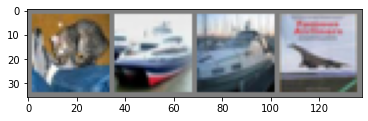

In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 69 %
Accuracy of plane : 72 %
Accuracy of   car : 80 %
Accuracy of  bird : 59 %
Accuracy of   cat : 45 %
Accuracy of  deer : 66 %
Accuracy of   dog : 74 %
Accuracy of  frog : 70 %
Accuracy of horse : 72 %
Accuracy of  ship : 74 %
Accuracy of truck : 75 %
